In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

## Data Cleaning

Fill in missing values, smooth noisy data, identify or remove outliers, and resolve inconsistencies

In [2]:
df = pd.read_excel('TIMSS2019.xlsx', index_col=0)

# drop columns that contain only null value
df = df.dropna(how='all', axis='columns')
# drop rows that contain only null value (NOT NEEDED)
df = df.dropna(how='all', axis='rows')

# drop rows that contain at least one `np.NaN` value in scores
df = df.dropna(how='any', axis='rows')

df = df.replace(to_replace=["A","B","C","D","E"], value=[5,4,3,2,1])

# make sure indexes pair with number of rows
df = df.reset_index()

Read data from codebook:

1. Variable
2. Missing Scheme Detailed: SPSS
3. Value Scheme Detailed

In [3]:
xls = pd.ExcelFile('T2019_G8_Codebook.xlsx')

df_BCGM = pd.read_excel(xls, 'BCGM7',  usecols=["Variable", "Missing Scheme Detailed: SPSS", "Value Scheme Detailed"])
df_BSGM = pd.read_excel(xls, 'BSGM7',  usecols=["Variable", "Missing Scheme Detailed: SPSS", "Value Scheme Detailed"])
df_BTMM = pd.read_excel(xls, 'BTMM7',  usecols=["Variable", "Missing Scheme Detailed: SPSS", "Value Scheme Detailed"])

In [4]:
df_BCGM['Missing Scheme Detailed: SPSS'] = df_BCGM['Missing Scheme Detailed: SPSS'].str.split(':', expand=True).iloc[:, 0]
df_BSGM['Missing Scheme Detailed: SPSS'] = df_BSGM['Missing Scheme Detailed: SPSS'].str.split(':', expand=True).iloc[:, 0]
df_BTMM['Missing Scheme Detailed: SPSS'] = df_BTMM['Missing Scheme Detailed: SPSS'].str.split(':', expand=True).iloc[:, 0]

Concat diffrent codebook's sheets

In [5]:
commons = list(set(df.columns).intersection(set(df_BCGM['Variable'])))
df_BCGM = df_BCGM.loc[df_BCGM['Variable'].isin(commons)]

commons = list(set(df.columns).intersection(set(df_BSGM['Variable'])))
df_BSGM = df_BSGM.loc[df_BSGM['Variable'].isin(commons)]

commons = list(set(df.columns).intersection(set(df_BTMM['Variable'])))
df_BTMM = df_BTMM.loc[df_BTMM['Variable'].isin(commons)]

codebook = pd.concat([df_BCGM, df_BSGM, df_BTMM], ignore_index=True)
codebook.drop_duplicates(subset='Variable', keep=False, inplace=True)

### Missing Values

In [6]:
for index, row in codebook.iterrows():
    df[row['Variable']].replace(int(row['Missing Scheme Detailed: SPSS']), np.NaN, inplace=True)

In [7]:
scores = ['finalscore', 'finalscorealgebra', 'finalscoredat', 'finalscoregeo', 'finalscorenum']

df.dropna(subset=scores, how='any', inplace=True)

Cleaning data

- categorical : replace `np.NaN` with mode
- numeric : replace with median

In [8]:
for column in df.columns[11:]:
    # categorical or numerical
    cond = codebook.loc[codebook['Variable'] == column]['Missing Scheme Detailed: SPSS'] == 9
    if cond.all():
        # replace categorical with mode
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        # replace numerical with median
        df[column].fillna(df[column].median(), inplace=True)


### Outliers

In [9]:
codebook['Value Scheme Detailed'].fillna('-', inplace=True)

numerical_cols = []
for index, row in codebook.iterrows():
    if row['Value Scheme Detailed'] == '-':
        numerical_cols.append(row.Variable)

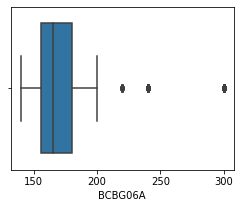

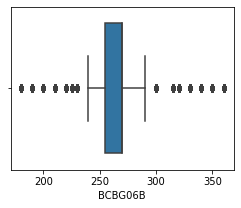

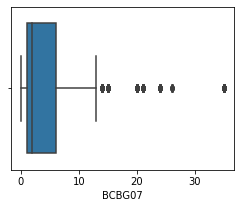

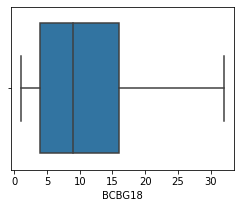

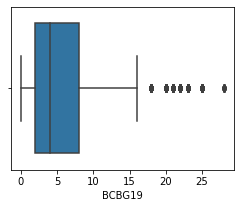

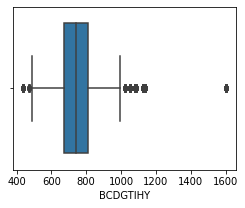

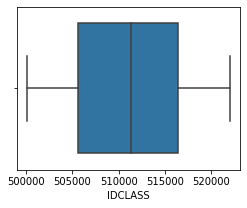

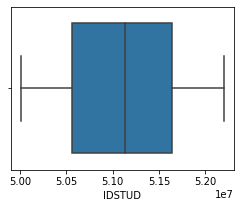

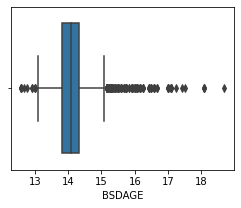

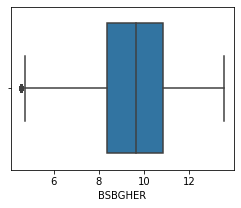

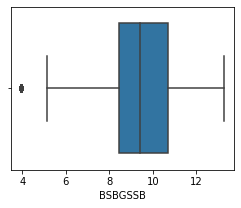

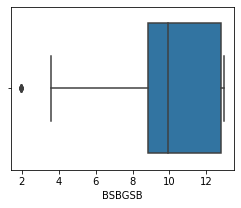

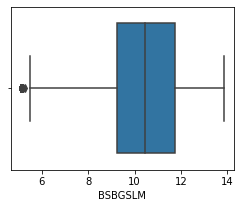

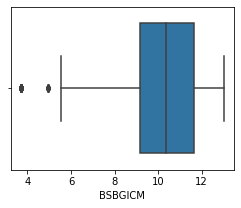

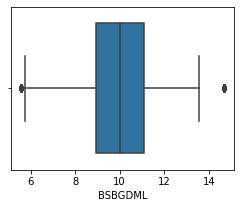

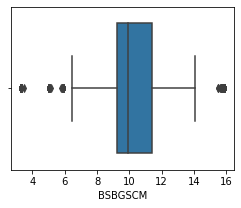

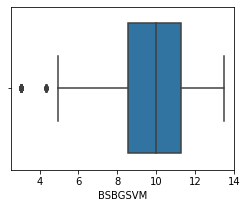

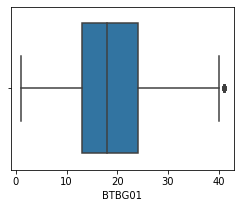

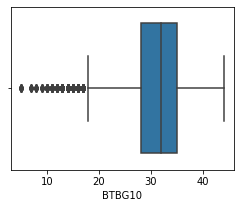

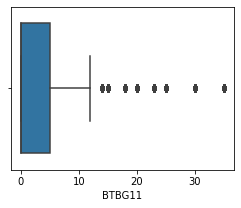

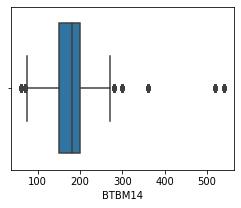

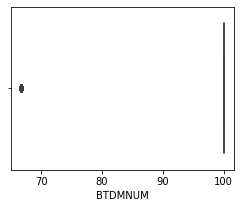

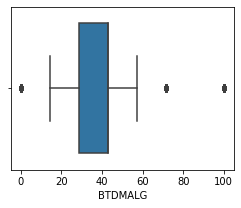

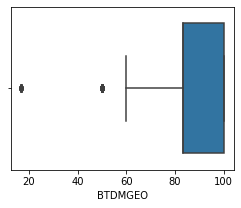

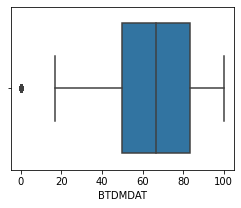

In [10]:
for column in numerical_cols:
    plt.figure(figsize = (4 , 3))
    sns.axes_style('darkgrid')
    sns.boxplot(x=df[column])

Outlier detection with z-score method

In [11]:
for column in numerical_cols:
    z_score = (df[column] - df[column].mean())/df[column].std(ddof=0)
    mask = np.abs(z_score)>3.0
    df.loc[mask, column] = df[column].mean()

## Data Mining

### Question 1

In [12]:
corr = df.iloc[:,2:].corr()
corr = abs(corr[["finalscore"]])
corr = corr[9:]
corr
# UNCOMMENT THIS LINE FOR VISUALIZE ALL CORROLATIONS
# corr.style.background_gradient(cmap='coolwarm')

,finalscore
BSBG01,0.008318
BSBG03,0.163941
BSBG04,0.335360
BSBG05A,0.213101
BSBG05B,0.224614
...,...
BTDMMME,0.017381
BTDMNUM,0.081669
BTDMALG,0.002409
BTDMGEO,0.010073


In [13]:
top5 = corr.sort_values(by='finalscore', ascending=False)[:5]
top5.style.background_gradient(cmap='coolwarm')

,finalscore
BSBGSCM,0.414847
BSBGHER,0.385587
BSDGSCM,0.383404
BSBM19H,0.338220
BSBG04,0.335360


As observed in the above figure, 5 factors affect the students' scores, including variables *BSBGSCM*, *BSBGHER*, *BSDGSCM*, *BSBM19H*, and *BSBG04*. According to the guide, the variable *BSBGSCM* represents the level of self-confidence of the student, and the variable *BSBGHER* indicates educational resources at home.

### Question 2

In [14]:
boy_df = df.loc[df['BSBG01'] == 2]
girl_df = df.loc[df['BSBG01'] == 1]

corr_boy = boy_df.iloc[:, 2:].corr()
corr_boy_target = abs(corr_boy[["finalscore"]])
corr_boy_target = corr_boy_target[10:]

corr_girl = girl_df.iloc[:, 2:].corr()
corr_girl_target = abs(corr_girl[["finalscore"]])
corr_girl_target = corr_girl_target[10:]

corr_dif = corr_boy_target - corr_girl_target
corr_dif
# UNCOMMENT THIS LINE FOR VISUALIZE ALL CORROLATIONS
# corr_dif.style.background_gradient(cmap='coolwarm')


,finalscore
BSBG03,0.061499
BSBG04,0.080202
BSBG05A,0.045242
BSBG05B,0.066463
BSBG05C,0.015174
...,...
BTDMMME,0.025287
BTDMNUM,0.123734
BTDMALG,-0.008217
BTDMGEO,-0.023476


In [15]:
top5 = corr_dif.sort_values(by='finalscore', ascending=False)[:5]
top5.style.background_gradient(cmap='coolwarm')

,finalscore
BCBG03B,0.221271
BCBG09,0.203242
BCBG20,0.199025
BCBG15E,0.172964
BCBG14E,0.165808


Let's first separate the data related to female and male students, and calculate the correlation separately for each of the two groups. The difference between these two values ​​shows the difference in the effect of each background factor on female and male students. After applying the above calculations, the results indicate that there is no significant difference between female and male students. However, the greatest difference is related to the factors *BSBG03B*, *BCBG09*, *BCBG20*, *BCBG15E*, and *BCBG14E*.

### Question 3

In [16]:
corr = df.iloc[:,2:].corr()
corr = abs(corr[["finalscorealgebra", "finalscoredat", "finalscoregeo", "finalscorenum"]])
corr = corr[9:]
corr
# UNCOMMENT THIS LINE FOR VISUALIZE ALL CORROLATIONS
# corr.style.background_gradient(cmap='coolwarm')

,finalscorealgebra,finalscoredat,finalscoregeo,finalscorenum
BSBG01,0.056419,0.009109,0.011321,0.027655
BSBG03,0.138795,0.097750,0.089058,0.109112
BSBG04,0.272435,0.204799,0.200901,0.282764
BSBG05A,0.179311,0.136693,0.122227,0.165845
BSBG05B,0.184595,0.138413,0.128743,0.156723
...,...,...,...,...
BTDMMME,0.001154,0.021079,0.015226,0.023166
BTDMNUM,0.071172,0.045965,0.043856,0.054799
BTDMALG,0.003198,0.008895,0.002337,0.003454
BTDMGEO,0.012209,0.005618,0.003133,0.017537


In [17]:
top5_alg = corr[['finalscorealgebra']].sort_values(by='finalscorealgebra', ascending=False)[:5]
top5_alg.style.background_gradient(cmap='coolwarm')

,finalscorealgebra
BSBGSCM,0.350379
BSDGSCM,0.321366
BSBGHER,0.315942
BSBM19H,0.276110
BSBG04,0.272435


In [18]:
top5_dat = corr[['finalscoredat']].sort_values(by='finalscoredat', ascending=False)[:5]
top5_dat.style.background_gradient(cmap='coolwarm')

,finalscoredat
BSBGHER,0.232233
BSBGSCM,0.222503
BSDGSCM,0.216491
BSBG04,0.204799
BSDGHER,0.204677


In [19]:
top5_geo = corr[['finalscoregeo']].sort_values(by='finalscoregeo', ascending=False)[:5]
top5_geo.style.background_gradient(cmap='coolwarm')

,finalscoregeo
BSBGSCM,0.249574
BSBGHER,0.233903
BSDGSCM,0.230207
BSDGEDUP,0.206009
BSBM19H,0.205048


In [20]:
top5_num = corr[['finalscorenum']].sort_values(by='finalscorenum', ascending=False)[:5]
top5_num.style.background_gradient(cmap='coolwarm')

,finalscorenum
BSBGSCM,0.351194
BSDGSCM,0.319256
BSBGHER,0.318300
BSBM19H,0.290074
BSBG04,0.282764


The above tables show the top 5 factors influencing the grades of students in different sections such as engineering, algebra, etc., and the level of impact of each one. According to the table, the factor *BSBGSCM* has the greatest impact on algebra grades, *BSBGHER* on data grades, *BSBGSCM* on geometry grades, and *BSBGCM* on number grades.